In [4]:
import os
from datetime import datetime, timedelta
import random

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from kornia.geometry.transform import warp_perspective
import torchvision.models as models
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision import transforms
from torch.utils.data import Dataset, ConcatDataset
import torchvision.utils as vutils

class TransformedImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, homography_matrices=None, num_samples=None):
        self.root_dir = root_dir
        self.transform = transform
        self.homography_matrices = homography_matrices
        self.num_samples = num_samples  # Number of samples to return
        
        self.image_paths = []  # List to store paths of all images
        self.labels = []  # List to store subdirectory names as labels
        
        # Create a mapping between class names and numerical indices
        self.class_to_index = {class_name: i for i, class_name in enumerate(sorted(set(os.listdir(root_dir))))}
        
        for root, dirs, files in os.walk(root_dir):
            for subdir in dirs:
                subdir_path = os.path.join(root, subdir)
                for file in os.listdir(subdir_path):
                    if file.endswith(('png', 'jpg', 'jpeg')):
                        self.image_paths.append(os.path.join(subdir_path, file))
                        self.labels.append(self.class_to_index[subdir])
        
        self.num_images = len(self.image_paths)
        
    def __len__(self):
        if self.num_samples:
            return min(self.num_images, self.num_samples)
        else:
            return self.num_images
    
    def __getitem__(self, idx):
        # Load original image
        original_image = Image.open(self.image_paths[idx]).convert('RGB')
    
        # Apply homographic transformation to create input image
        input_image = original_image.copy()
        if self.homography_matrices is not None:
            if random.randint(0,2) > 0:
                homography_matrix = random.choice(self.homography_matrices)
                input_image = cv2.warpPerspective(np.array(input_image), homography_matrix, (input_image.size[0], input_image.size[1]))
                input_image = Image.fromarray(input_image)
    
        # Apply transformations if specified
        if self.transform:
            original_image = self.transform(original_image)
            input_image = self.transform(input_image)
    
        label = self.labels[idx]
        return input_image, original_image, label

# Define multiple homography matrices with slightly more pronounced variations
homography_matrices = [
    np.array([[1.03, 0.02, 0.0], [0.02, 1.03, 0.0], [0.002, -0.001, 1.0]]),
    np.array([[0.02, 1.03, 0.0], [1.03, 0.02, 0.0], [0.002, -0.001, 1.0]])
]

# Define transform for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define path to the root folder containing subdirectories with images
root_dir = 'train'
train_dataset = TransformedImageDataset(root_dir=root_dir, transform=transform, homography_matrices=None)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
root_dir = 'test'
test_data = TransformedImageDataset(root_dir=root_dir, transform=transform, homography_matrices=None)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

test_data_alt = TransformedImageDataset(root_dir=root_dir, transform=transform, homography_matrices=homography_matrices)
test_dataloader_alt = DataLoader(test_data_alt, batch_size=32, shuffle=True)

In [5]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)  # Flatten before passing to fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
device = "cuda"

In [6]:
num_classes = len(set(train_dataset.labels))
classifier = CNN(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    for inputs, _, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # Print average loss per epoch
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished.")

# Save the trained model
torch.save(classifier.state_dict(), 'cnn_classifier.pth')

Epoch [1/10], Loss: 2.4741
Epoch [2/10], Loss: 0.2521
Epoch [3/10], Loss: 0.1265
Epoch [4/10], Loss: 0.0434
Epoch [5/10], Loss: 0.0196
Epoch [6/10], Loss: 0.0191
Epoch [7/10], Loss: 0.0075
Epoch [8/10], Loss: 0.0064
Epoch [9/10], Loss: 0.0058
Epoch [10/10], Loss: 0.0053
Training finished.


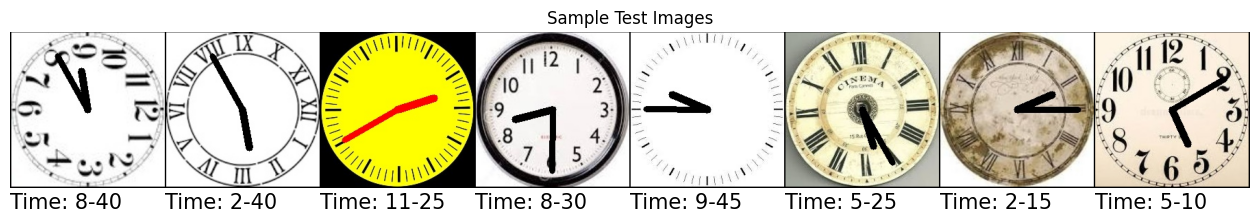

Accuracy on normal test data: 99.72%


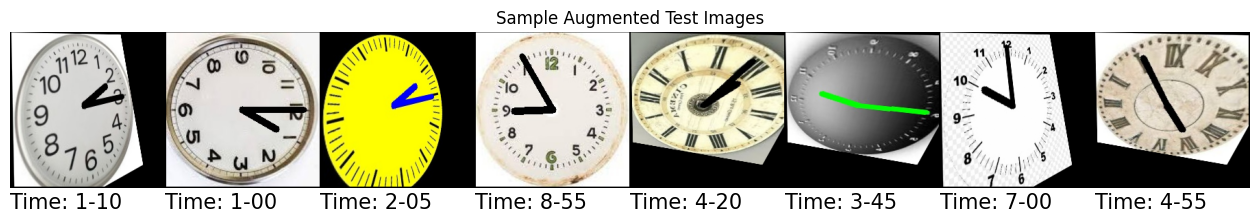

Accuracy on normal augmented test data: 41.18%


In [6]:
time_labels = []
for hour in range(1, 13):
    for minute in range(0, 56, 5):
        minute_str = "{:02d}".format(minute)
        time_labels.append(f"{hour}-{minute_str}")
time_labels.sort()

classifier = CNN(num_classes=144).to(device)
#classifier.load_state_dict(torch.load("cnn_classifier.pth", map_location=device))
batch = next(iter(test_dataloader))

input_images, _, labels = batch
outputs = classifier(input_images.to(device))
_, predicted = torch.max(outputs, 1)
pred_time = []
for item in predicted:
    pred_time.append(time_labels[item])

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Sample Test Images")
img_grid = np.transpose(vutils.make_grid(input_images[:8], padding=2, normalize=True).cpu(), (1, 2, 0))
plt.imshow(img_grid)

# Annotate each image with predicted time
for i, time in enumerate(pred_time[:8]):
    plt.text(i * img_grid.shape[1] // 8, img_grid.shape[0] + 30, f"Time: {time}", fontsize=15, ha='left')
plt.show()

classifier.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, _, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = classifier(inputs)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct / total
print(f"Accuracy on normal test data: {accuracy:.2%}")

# Get a batch of data from the data loader
batch = next(iter(test_dataloader_alt))
# Unpack the batch
input_images, _, _ = batch
outputs = classifier(input_images.to(device))
_, predicted = torch.max(outputs, 1)
pred_time = []
for item in predicted:
    pred_time.append(time_labels[item])

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Sample Augmented Test Images")
img_grid = np.transpose(vutils.make_grid(input_images[:8], padding=2, normalize=True).cpu(), (1, 2, 0))
plt.imshow(img_grid)

# Annotate each image with predicted time
for i, time in enumerate(pred_time[:8]):
    plt.text(i * img_grid.shape[1] // 8, img_grid.shape[0] + 30, f"Time: {time}", fontsize=15, ha='left')
plt.show()

classifier.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, _, labels in test_dataloader_alt:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = classifier(inputs)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct / total
print(f"Accuracy on normal augmented test data: {accuracy:.2%}")

In [7]:
def draw_cylinder_clock(ax, time, body_color, marking_color, hand_color, second_hand_color, random_face_color, marker_type):
    ax.grid(False)  # Remove grid lines for the clock body
    # Clock body as a solid cylinder
    z_body = np.linspace(-0.0004, 0.0004, 10)  # Reduced height for the body
    theta_body = np.linspace(0, 2 * np.pi, 100)
    Z_body, Theta_body = np.meshgrid(z_body, theta_body)
    R_body = np.ones_like(Z_body) * 0.5  # Radius of the clock body
    X_body = R_body * np.cos(Theta_body)
    Y_body = R_body * np.sin(Theta_body)

    # Draw cylinder body
    ax.plot_surface(X_body, Y_body, Z_body, color=body_color, edgecolor=body_color, lw=3, zorder=100)  # Set lw=0 to remove mesh lines

    # Draw end caps for the body
    cap_radius = 0.5
    for z_cap in [-0.0006]:  # Positions of the end caps
        end_cap_points = []
        for theta in np.linspace(0, 2 * np.pi, 100):
            x = cap_radius * np.cos(theta)
            y = cap_radius * np.sin(theta)
            end_cap_points.append([x, y, z_cap])
        end_cap_points = np.array(end_cap_points)
        end_cap_poly = Poly3DCollection([end_cap_points], color=random_face_color, edgecolor='black')
        ax.add_collection3d(end_cap_poly)

    ax.grid(False)  # Remove grid lines for the hour markings and numbers
    for hour in range(1, 13):
        hour_angle = np.radians(30 * (12 - hour))
        x = 0.4 * np.cos(hour_angle)
        y = 0.4 * np.sin(hour_angle)
        if marker_type < 5:
            ax.text(x, y, 0.0006, str(hour), color=marking_color, fontsize=30, ha='center', va='center')
        else:
            ax.text(x, y, 0.0006, str(hour), color=marking_color, fontsize=30, ha='center', va='center')
            #ax.plot([0.45 * np.cos(hour_angle), 0.4 * np.cos(hour_angle)], [0.45 * np.sin(hour_angle), 0.4 * np.sin(hour_angle)], [0.0005, 0.0005], color=marking_color, zorder=6, linewidth=3)

    # Hour hand
    ax.grid(False)  # Remove grid lines for the hour hand
    hour_angle = np.radians(360 - ((time.hour % 12) * 30 + time.minute * 0.5))
    ax.plot([0, 0.2 * np.cos(hour_angle)], [0, 0.2 * np.sin(hour_angle)], [0.0005, 0.0005], color=hand_color, zorder=10, linewidth=15)

    # Minute hand
    ax.grid(False)  # Remove grid lines for the minute hand
    minute_angle = np.radians(360 - (time.minute * 6))
    ax.plot([0, 0.3 * np.cos(minute_angle)], [0, 0.3 * np.sin(minute_angle)], [0.0005, 0.0005], color=hand_color, zorder=10, linewidth=14)

    # Second hand
    #ax.grid(False)  # Remove grid lines for the second hand
    #second_angle = np.radians(time.second * 6)
    #ax.plot([0, 0.28 * np.cos(second_angle)], [0, 0.28 * np.sin(second_angle)], [0.0005, 0.0005], color=second_hand_color, zorder=10, linewidth=1)

def draw_rectangular_clock(ax, time, body_color, marking_color, hand_color, second_hand_color, random_face_color, marker_type):
    ax.grid(False)  # Remove grid lines for the clock body
    # Clock body as a solid rectangular prism
    x_body = np.array([-0.6, 0.6, 0.6, -0.6, -0.6])
    y_body = np.array([-0.6, -0.6, 0.6, 0.6, -0.6])
    z_body = np.array([0.0005, 0.0005, 0.0005, 0.0005, 0.0005])  # Original border height
    ax.plot(x_body, y_body, z_body, color=body_color, lw=2)  # Draw clock body
    z_body = np.array([0.0006, 0.0006, 0.0006, 0.0006, 0.0006])
    ax.plot(x_body, y_body, z_body, color=body_color, lw=2)  # Draw clock body
    z_body = np.array([0.00055, 0.00055, 0.00055, 0.00055, 0.00055])
    ax.plot(x_body, y_body, z_body, color=body_color, lw=2)  # Draw clock body

    # Draw end caps for the body
    cap_height = 0.0008  # Height of the end caps
    cap_points = [[-0.57, -0.57, cap_height], [0.57, -0.57, cap_height], [0.57, 0.57, cap_height], [-0.57, 0.57, cap_height]]
    cap_poly = Poly3DCollection([cap_points], color=random_face_color, edgecolor='black')
    ax.add_collection3d(cap_poly)

    # Hour markings and numbers
    for hour in range(1, 13):
        hour_angle = np.radians(30 * (12 - hour))
        x = 0.4 * np.cos(hour_angle)
        y = 0.4 * np.sin(hour_angle)
        if marker_type < 5:
            ax.text(x, y, 0.0006, str(hour), color=marking_color, fontsize=30, ha='center', va='center')
        else:
            ax.text(x, y, 0.0006, str(hour), color=marking_color, fontsize=30, ha='center', va='center')
            #ax.plot([0.45 * np.cos(hour_angle), 0.4 * np.cos(hour_angle)], [0.45 * np.sin(hour_angle), 0.4 * np.sin(hour_angle)], [0.0005, 0.0005], color=marking_color, zorder=6, linewidth=3)

    # Hour hand
    hour_angle = np.radians(360 - ((time.hour % 12) * 30 + time.minute * 0.5))
    ax.plot([0, 0.2 * np.cos(hour_angle)], [0, 0.2 * np.sin(hour_angle)], [0.0005, 0.0005], color=hand_color, zorder=10, linewidth=15)

    # Minute hand
    minute_angle = np.radians(360 - (time.minute * 6))
    ax.plot([0, 0.3 * np.cos(minute_angle)], [0, 0.3 * np.sin(minute_angle)], [0.0005, 0.0005], color=hand_color, zorder=10, linewidth=14)

    # Second hand
    #second_angle = np.radians(time.second * 6)
    #ax.plot([0, 0.28 * np.cos(second_angle)], [0, 0.28 * np.sin(second_angle)], [0.0005, 0.0005], zorder=10, color=second_hand_color, linewidth=1)

class ClockDataset(Dataset):
    def __init__(self, num_samples, transform=None):
        self.num_samples = num_samples
        self.transform = transform
        self.labels = []
        for hour in range(1, 13):
            for minute in range(0, 56, 5):
                minute_str = "{:02d}".format(minute)
                self.labels.append(f"{hour}-{minute_str}")
        self.labels.sort()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate random clock properties
        clock_type = np.random.choice(['cylindrical', 'rectangular'])
        angle_x = np.random.randint(20, 80)
        angle_y = np.random.randint(180, 200)
        angle_z = np.random.randint(60, 80)
        random_body_color = np.random.rand(3)
        random_marking_color = np.random.rand(3)
        random_hand_color = np.random.rand(3)
        random_second_hand_color = np.random.rand(3)
        random_face_color = np.random.rand(3)
        marker_type = np.random.randint(0, 8)
        random_time = datetime.now() - timedelta(hours=random.randint(0, 24))
        random_time = random_time.replace(minute=random.choice(range(0, 56, 5)))
        hour_minute_str = random_time.strftime("%I-%M").lstrip('0')

        # Generate clock image
        clock_image = self.generate_clock_image(clock_type, angle_x, angle_y, angle_z, random_body_color, random_marking_color, random_hand_color, random_second_hand_color, random_face_color, marker_type, random_time)
        clock_image = Image.fromarray(clock_image)
        clock_image = self.transform(clock_image) if self.transform else np.array(clock_image)
        
        label_image = self.generate_clock_image(clock_type, 90, 180, 210, random_body_color, random_marking_color, random_hand_color, random_second_hand_color, random_face_color, marker_type, random_time)
        label_image = Image.fromarray(label_image)
        label_image = self.transform(label_image) if self.transform else np.array(label_image)
        index = np.where(np.array(self.labels) == hour_minute_str)[0]
        return clock_image, label_image, index[0]

    def generate_clock_image(self, clock_type, angle_x, angle_y, angle_z, body_color, marking_color, hand_color, second_hand_color, random_face_color, marker_type, random_time):
        if clock_type == 'cylindrical':
            fig = plt.figure(figsize=(10, 10), facecolor='none')
            ax = fig.add_subplot(111, projection='3d')
            ax.grid(False)  # Remove grid lines for the overall plot
            ax.set_xlim([-0.4, 0.4])  # Adjust the limits to tightly fit around the clock
            ax.set_ylim([-0.4, 0.4])
            ax.set_zlim([-0.01, 0.01])  # Set a small height for the clock prism
            ax.view_init(elev=angle_x, azim=angle_y)
            
            # Hide the axes, ticks, and labels
            ax.set_axis_off()
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
    
            # Set background color to transparent
            ax.patch.set_alpha(0)
            draw_cylinder_clock(ax, random_time, body_color, marking_color, hand_color, second_hand_color, random_face_color, marker_type)
        elif clock_type == 'rectangular':
            fig = plt.figure(figsize=(10, 10), facecolor='none')
            ax = fig.add_subplot(111, projection='3d')
            ax.grid(False)  # Remove grid lines for the overall plot
            ax.set_xlim([-0.56, 0.56])  # Adjust the limits to tightly fit around the clock
            ax.set_ylim([-0.56, 0.56])
            ax.set_zlim([-0.01, 0.01])  # Set a small height for the clock prism
            ax.view_init(elev=angle_x, azim=angle_y)
            
            # Hide the axes, ticks, and labels
            ax.set_axis_off()
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
    
            # Set background color to transparent
            ax.patch.set_alpha(0)
            draw_rectangular_clock(ax, random_time, body_color, marking_color, hand_color, second_hand_color, random_face_color, marker_type)

        fig.canvas.draw()
        width, height = fig.canvas.get_width_height()
        clock_image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
        clock_image = clock_image[:, :, :3]
        plt.close(fig)
        return clock_image


# Define a function to normalize images
def normalize_image(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image

syn_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(150),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

num_samples = 5
clock_dataset = ClockDataset(num_samples, syn_transform)
data_loader = torch.utils.data.DataLoader(clock_dataset, batch_size=1, shuffle=True)

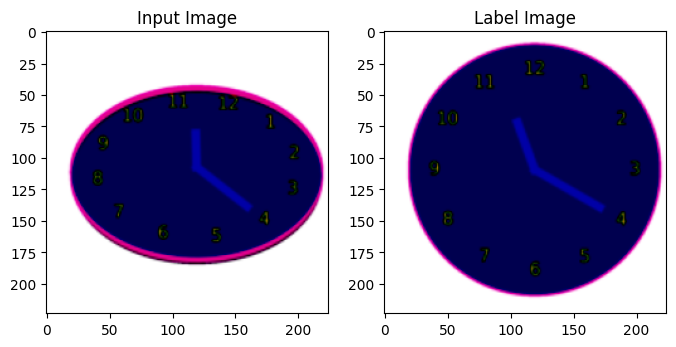

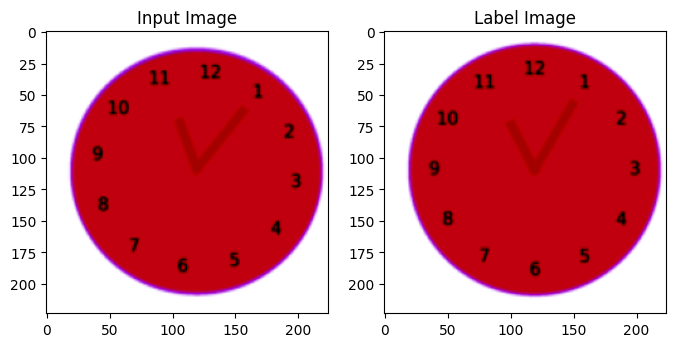

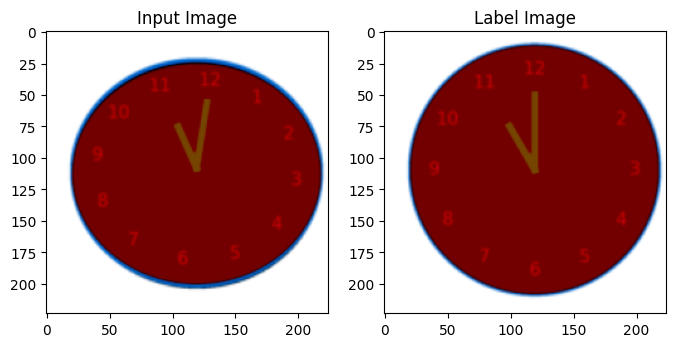

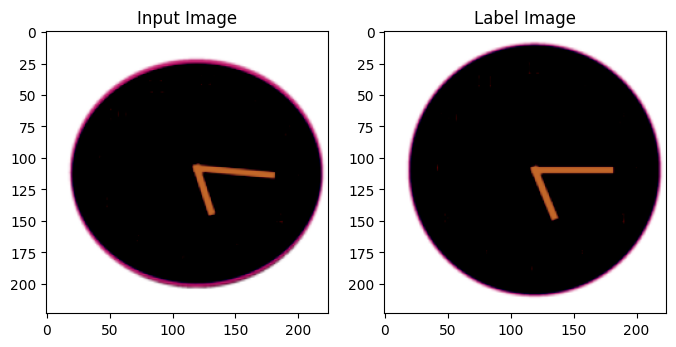

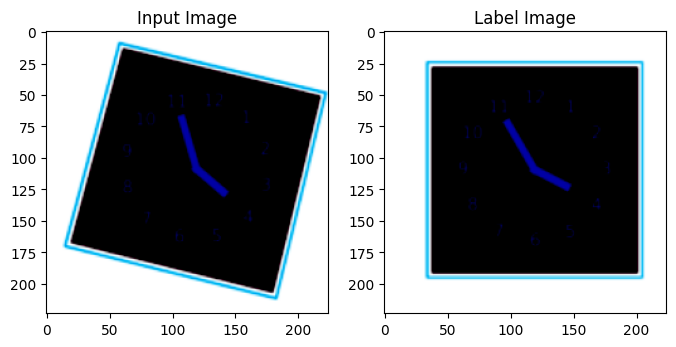

In [8]:
for i, data in enumerate(data_loader, 1):
    input_image, label_image, _ = data
    input_image_np = input_image.squeeze().permute(1, 2, 0).numpy()
    label_image_np = label_image.squeeze().permute(1, 2, 0).numpy()
    
    # Clip pixel values to valid range [0, 1]
    input_image_np = np.clip(input_image_np, 0, 255)
    label_image_np = np.clip(label_image_np, 0, 255)
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image_np)
    plt.title('Input Image')
    plt.subplot(1, 2, 2)
    plt.imshow(label_image_np)
    plt.title('Label Image')
    plt.show()
    
    if i == num_samples:
        break

In [3]:
root_dir = 'syn_train'
clock_dataset = ClockDataset(2300, syn_transform)
data_loader = torch.utils.data.DataLoader(clock_dataset, batch_size=32, shuffle=True)

labels = []
for hour in range(1, 13):
    for minute in range(0, 60, 5):
        minute_str = "{:02d}".format(minute)
        labels.append(f"{hour}-{minute_str}")
labels.sort()

for batch_idx, batch in enumerate(data_loader):
    input_images, label_images, label = batch
    for i in range(len(label)):
        label_dir = os.path.join(root_dir, str(labels[label[i].item()]))
        os.makedirs(label_dir, exist_ok=True)
        image = transforms.ToPILImage()(label_images[i])
        image_np = np.array(image)
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min()) * 255
        image_normalized = Image.fromarray(image_np.astype(np.uint8))
        image_path = os.path.join(label_dir, f'{i}.png')
        image_normalized.save(image_path)

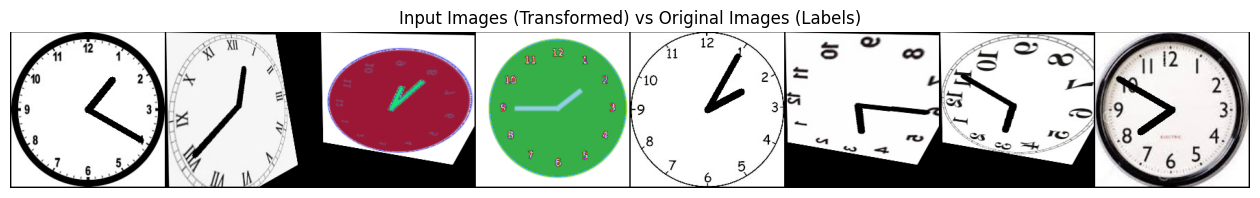

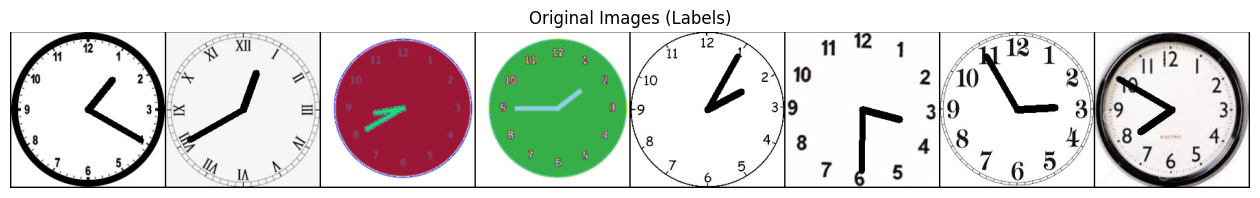

In [9]:
basic_dataset = TransformedImageDataset(root_dir="train", transform=transform, homography_matrices=homography_matrices)
syn_dataset = TransformedImageDataset(root_dir="syn_train", transform=transform, homography_matrices=homography_matrices)
final_dataset = ConcatDataset([syn_dataset, basic_dataset])
final_data_loader = torch.utils.data.DataLoader(final_dataset, batch_size=32, shuffle=True)
# Get a batch of data from the data loader
batch = next(iter(final_data_loader))

# Unpack the batch
input_images, label_images, label = batch

# Plot the images
plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Input Images (Transformed) vs Original Images (Labels)")
plt.imshow(np.transpose(vutils.make_grid(input_images[:8], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Original Images (Labels)")
plt.imshow(np.transpose(vutils.make_grid(label_images[:8], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()


In [14]:
device = "cuda"
num_classes = 144
classifier = CNN(num_classes=num_classes).to(device)
classifier.load_state_dict(torch.load("cnn_improved_classifier.pth", map_location=device))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    for inputs, _, labels in final_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    # Print average loss per epoch
    epoch_loss = running_loss / len(final_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished.")

# Save the trained model
torch.save(classifier.state_dict(), 'cnn_improved_classifier.pth')

Epoch [1/10], Loss: 0.0189
Epoch [2/10], Loss: 0.0102
Epoch [3/10], Loss: 0.0065
Epoch [4/10], Loss: 0.0052
Epoch [5/10], Loss: 0.0046
Epoch [6/10], Loss: 0.0041
Epoch [7/10], Loss: 0.0036
Epoch [8/10], Loss: 0.0037
Epoch [9/10], Loss: 0.0033
Epoch [10/10], Loss: 0.0028
Training finished.


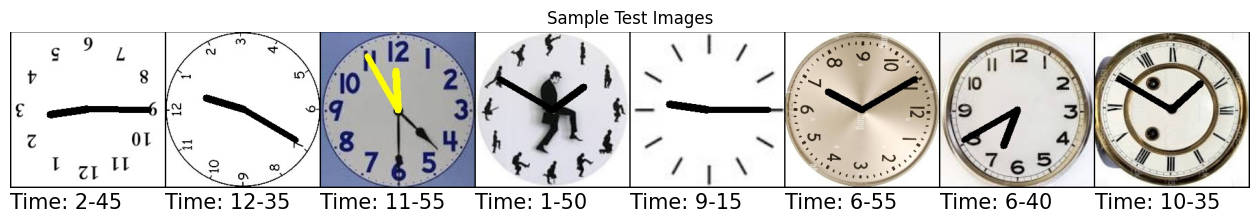

Accuracy on normal test data: 98.68%


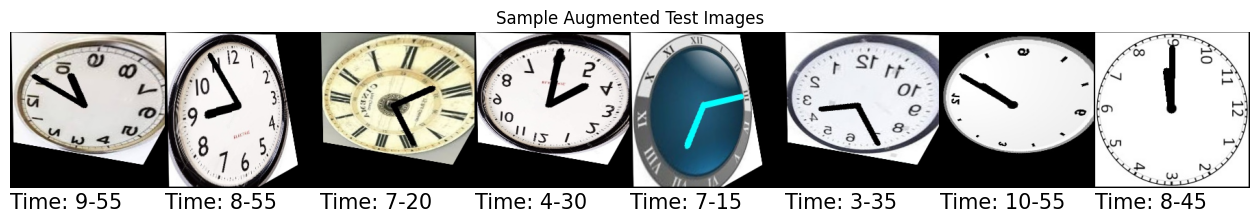

Accuracy on normal augmented test data: 99.31%


In [10]:
time_labels = []
for hour in range(1, 13):
    for minute in range(0, 56, 5):
        minute_str = "{:02d}".format(minute)
        time_labels.append(f"{hour}-{minute_str}")
time_labels.sort()

classifier = CNN(num_classes=144).to(device)
#classifier.load_state_dict(torch.load("cnn_improved_classifier.pth", map_location=device))
batch = next(iter(test_dataloader))

input_images, _, labels = batch
outputs = classifier(input_images.to(device))
_, predicted = torch.max(outputs, 1)
pred_time = []
for item in predicted:
    pred_time.append(time_labels[item])

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Sample Test Images")
img_grid = np.transpose(vutils.make_grid(input_images[:8], padding=2, normalize=True).cpu(), (1, 2, 0))
plt.imshow(img_grid)

# Annotate each image with predicted time
for i, time in enumerate(pred_time[:8]):
    plt.text(i * img_grid.shape[1] // 8, img_grid.shape[0] + 30, f"Time: {time}", fontsize=15, ha='left')
plt.show()

classifier.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, _, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = classifier(inputs)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct / total
print(f"Accuracy on normal test data: {accuracy:.2%}")

# Get a batch of data from the data loader
batch = next(iter(test_dataloader_alt))
# Unpack the batch
input_images, _, _ = batch
outputs = classifier(input_images.to(device))
_, predicted = torch.max(outputs, 1)
pred_time = []
for item in predicted:
    pred_time.append(time_labels[item])

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Sample Augmented Test Images")
img_grid = np.transpose(vutils.make_grid(input_images[:8], padding=2, normalize=True).cpu(), (1, 2, 0))
plt.imshow(img_grid)

# Annotate each image with predicted time
for i, time in enumerate(pred_time[:8]):
    plt.text(i * img_grid.shape[1] // 8, img_grid.shape[0] + 30, f"Time: {time}", fontsize=15, ha='left')
plt.show()

classifier.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, _, labels in test_dataloader_alt:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = classifier(inputs)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct / total
print(f"Accuracy on normal augmented test data: {accuracy:.2%}")